# Explore here

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv(r"D:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\LINEARREGRESSION\LinearRegressionProjectTutorial\data\raw\data.csv")

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.shape

(1338, 7)

In [5]:
#We check for duplicates
total_data = data.drop_duplicates().reset_index(drop = True)
total_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
data.shape

(1338, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


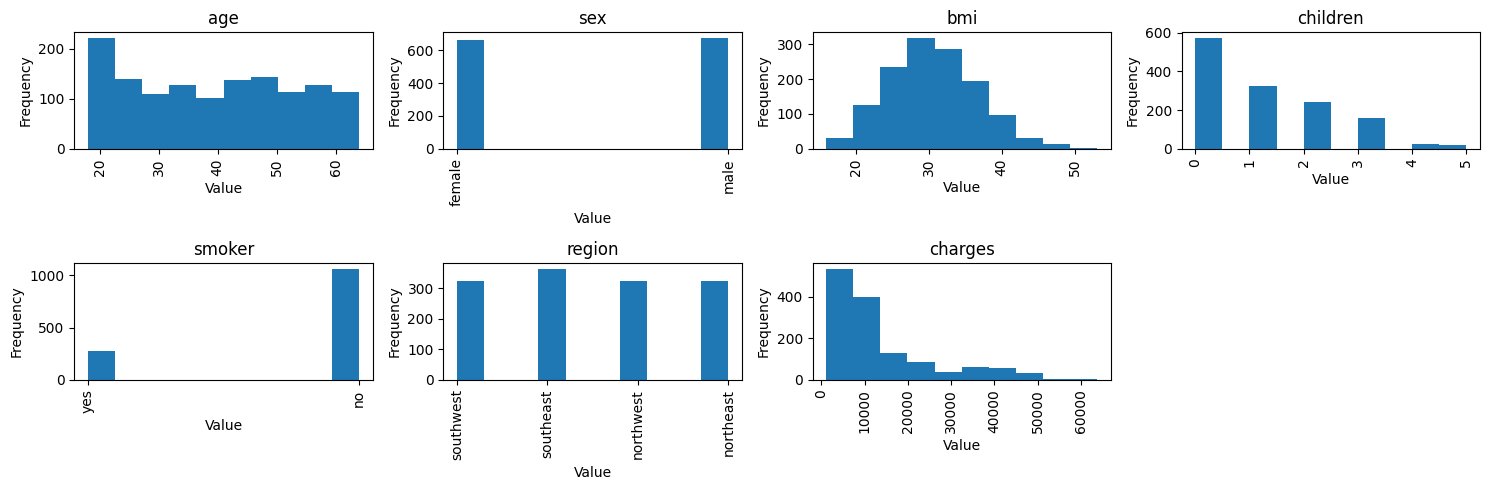

In [8]:
# We are going to visually display the different unique values and their ammounts into subplots.

# We generate the subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

axes_flat = axes.flatten()

# We iterate and plot histograms for each column.
for i, (ax, column) in enumerate(zip(axes_flat, data.columns)):
    ax.hist(data[column])
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)

for ax in axes_flat[len(data.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

The data reveals a clear majority of non-smokers and a balanced representation across regions and genders. The BMI distribution leans slightly right. Similarly, the number of children is right-skewed, with most having zero or few. The age distribution favors younger individuals, peaking around 20 years old.

We will now continue by transforming the data into numerical values, and standarise them to be able to work with it.

In [9]:
def label_encode_columns(df, columns_to_encode):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Dictionary to store encoding information
    encoding_dict = {}
    
    # Iterate over the specified columns
    for col in columns_to_encode:
            # Fit and transform the column
            df[col] = le.fit_transform(df[col].astype(str))
            
            # Store the encoding information in the dictionary
            encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    return df, encoding_dict

columns_to_encode = ['sex', 'smoker', 'region']

encoded_df, encoding_info = label_encode_columns(total_data, columns_to_encode)

print(encoded_df.head())

print("Encoding Information:")
for col, encoding in encoding_info.items():
    print(f"\n{col}:")
    for original, encoded in encoding.items():
        print(f"  {original}: {encoded}")

   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520
Encoding Information:

sex:
  female: 0
  male: 1

smoker:
  no: 0
  yes: 1

region:
  northeast: 0
  northwest: 1
  southeast: 2
  southwest: 3


Region has four different values, we will use one hot encoding to generate two columns, one with "is_north" where northeast and northwest = 1 and the column "is_east" where northeast and southeast = 1.

In [10]:
total_data['region'].value_counts()

region
2    364
3    325
1    324
0    324
Name: count, dtype: int64

In [11]:
# We create new columns for north/south and east/west
total_data['is_north'] = total_data['region'].isin([0, 1]).astype(int)
total_data['is_east'] = total_data['region'].isin([0, 2]).astype(int)

total_data.drop('region', axis=1, inplace=True)

# We print the first few rows of the modified dataframe
print(total_data.head())

# We print the value counts for the new columns to verify the encoding
print("Value counts for 'is_north':")
print(total_data['is_north'].value_counts())
print("Value counts for 'is_east':")
print(total_data['is_east'].value_counts())

   age  sex     bmi  children  smoker      charges  is_north  is_east
0   19    0  27.900         0       1  16884.92400         0        0
1   18    1  33.770         1       0   1725.55230         0        1
2   28    1  33.000         3       0   4449.46200         0        1
3   33    1  22.705         0       0  21984.47061         1        0
4   32    1  28.880         0       0   3866.85520         1        0
Value counts for 'is_north':
is_north
0    689
1    648
Name: count, dtype: int64
Value counts for 'is_east':
is_east
1    688
0    649
Name: count, dtype: int64


In [12]:
# List of non-binary columns to scale
non_binary_columns = ['age', 'bmi', 'children', 'charges']

def minmax_scale_columns(df, columns_to_scale):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Dictionary to store scaling information
    scaling_info = {}
    
    # We state the name of the new dataframe that will contain the scaled data.
    scaled_df = df.copy()
    
    # We iterate over the specified columns
    for col in columns_to_scale:
            # We reshape the data for scaling
            values = df[col].values.reshape(-1, 1)
            
            # We fit and transform the column
            scaled_values = scaler.fit_transform(values)
            
            # We update the dataframe with scaled values
            scaled_df[col] = scaled_values
            
            # We store the scaling information in the dictionary
            scaling_info[col] = {
                'min': scaler.data_min_[0],
                'max': scaler.data_max_[0]
            }    
    return scaled_df, scaling_info

# We apply MinMaxScaling
scaled_df, scaling_info = minmax_scale_columns(total_data, non_binary_columns)

# We print the first few rows of the scaled dataframe
print(scaled_df.head())

print("Scaling Information:")
for col, info in scaling_info.items():
    print(f"{col}:")
    print(f"  Original Min: {info['min']}")
    print(f"  Original Max: {info['max']}")

        age  sex       bmi  children  smoker   charges  is_north  is_east
0  0.021739    0  0.321227       0.0       1  0.251611         0        0
1  0.000000    1  0.479150       0.2       0  0.009636         0        1
2  0.217391    1  0.458434       0.6       0  0.053115         0        1
3  0.326087    1  0.181464       0.0       0  0.333010         1        0
4  0.304348    1  0.347592       0.0       0  0.043816         1        0
Scaling Information:
age:
  Original Min: 18.0
  Original Max: 64.0
bmi:
  Original Min: 15.96
  Original Max: 53.13
children:
  Original Min: 0.0
  Original Max: 5.0
charges:
  Original Min: 1121.8739
  Original Max: 63770.42801


In [13]:
non_binary_columns.remove('charges')

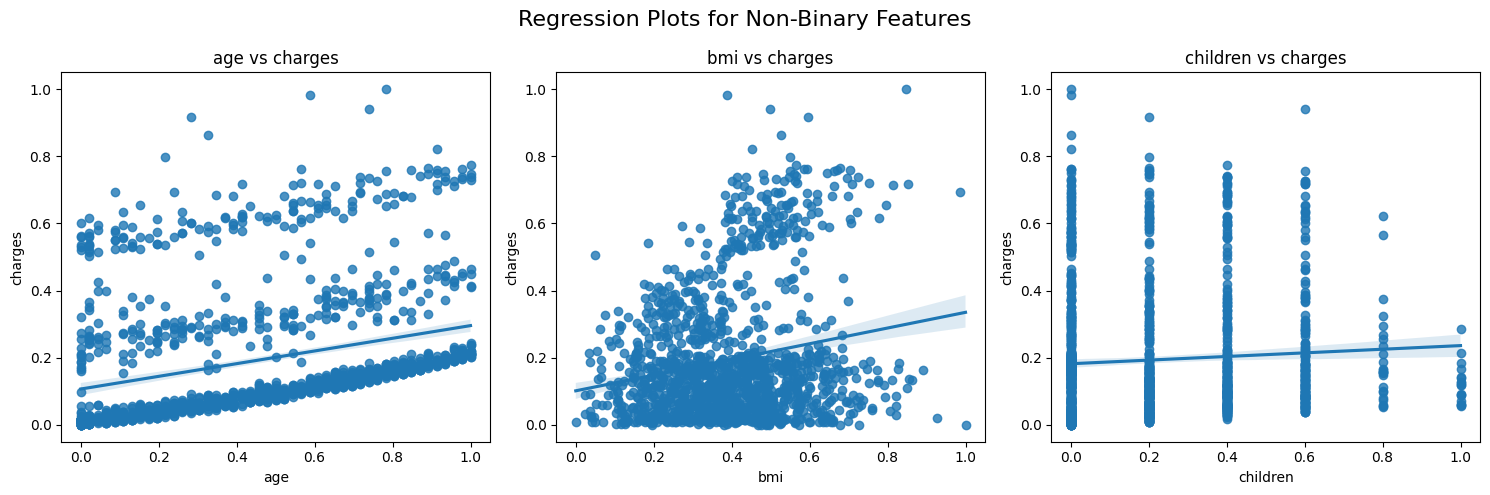

In [14]:
features = non_binary_columns
target = 'charges'

# We create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Regression Plots for Non-Binary Features', fontsize=16)

# We plot regplots for each feature
for i, feature in enumerate(features):
    sns.regplot(x=feature, y=target, data=scaled_df, ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')

plt.tight_layout()
plt.show()

In [15]:
summary_df = pd.DataFrame(columns=['Feature', 'Coefficient', 'P-value', 'R-squared'])

# We create a list to store results
results_list = []

for feature in features:
    X = scaled_df[feature]
    y = scaled_df[target]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # We store the results
    results_list.append({
        'Feature': feature,
        'Coefficient': model.params[feature],
        'P-value': model.pvalues[feature],
        'R-squared': model.rsquared
    })

# We create summary dataframe from the list of results
summary_df = pd.DataFrame(results_list)

print(summary_df)

    Feature  Coefficient       P-value  R-squared
0       age     0.188872  6.975749e-29   0.088988
1       bmi     0.233679  2.468040e-13   0.039363
2  children     0.054027  1.371703e-02   0.004541


In [16]:
X = scaled_df['bmi']
y = scaled_df['charges']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     54.70
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           2.47e-13
Time:                        22:39:43   Log-Likelihood:                 327.56
No. Observations:                1337   AIC:                            -651.1
Df Residuals:                    1335   BIC:                            -640.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1016      0.014      7.510      0.0

In [17]:
X = scaled_df['age']
y = scaled_df['charges']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     130.4
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           6.98e-29
Time:                        22:39:43   Log-Likelihood:                 363.01
No. Observations:                1337   AIC:                            -722.0
Df Residuals:                    1335   BIC:                            -711.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1069      0.009     11.686      0.0

We will proceed to train the data.

In [18]:
scaled_df.head()

,age,sex,bmi,children,smoker,charges,is_north,is_east
0,0.021739,0,0.321227,0.0,1,0.251611,0,0
1,0.000000,1,0.479150,0.2,0,0.009636,0,1
2,0.217391,1,0.458434,0.6,0,0.053115,0,1
3,0.326087,1,0.181464,0.0,0,0.333010,1,0
4,0.304348,1,0.347592,0.0,0,0.043816,1,0


In [19]:
target = 'charges'
features = [col for col in scaled_df.columns if col != target]

In [20]:
correlation_threshold = 0.06 
correlations = scaled_df.corr()[target].abs().sort_values(ascending=False)
selected_features = correlations[correlations > correlation_threshold].index.tolist()
selected_features.remove(target)

print("Selected features:", selected_features)

Selected features: ['smoker', 'age', 'bmi', 'is_east', 'children']


In [21]:
X = scaled_df[selected_features]
y = scaled_df[target]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = model.predict(X_test)

In [25]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 0.009147874867657196
R-squared Score: 0.8046107617260027


smoker: 0.36764295542389114
age: 0.1830306612525315
bmi: 0.18056246527552736
is_east: 0.0016155880746693552
children: 0.04299774206594176


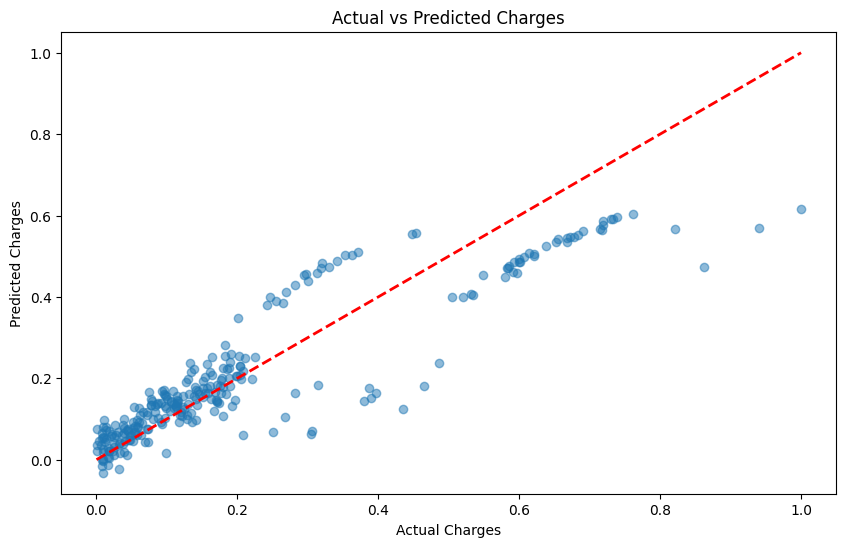

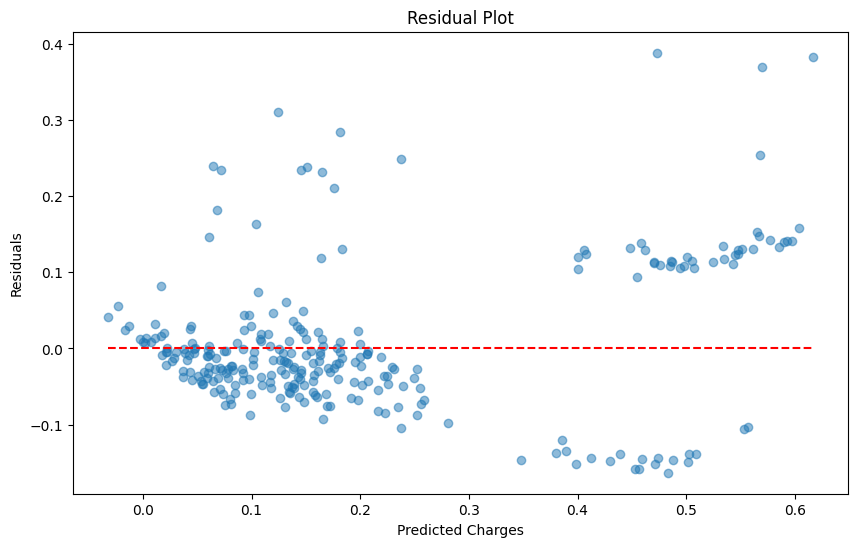

In [26]:
# Print feature coefficients
for feature, coef in zip(selected_features, model.coef_):
    print(f"{feature}: {coef}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

The model performs reasonably well, with smoking status, age, and BMI as key factors in predicting insurance charges. However, it struggles with high-cost predictions normally predicting under the expected price, indicating room for improvement.